In [28]:
from qiskit import *
from implementations.utils.helpers import *
from implementations.VBE.multiplier_VBE import c_mult_mod_VBE

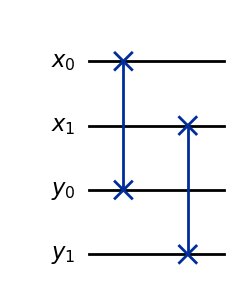

In [42]:
#swaps two registers
def swapper(num_qubits: int) -> QuantumCircuit:
    x = QuantumRegister(num_qubits, name="x")
    y = QuantumRegister(num_qubits, name="y")
    quantum_citcuit = QuantumCircuit(x,y)
    quantum_citcuit.name = "swapper"

    for i in range(num_qubits):
        quantum_citcuit.swap(x[i], y[i])
    return quantum_citcuit

swapper(2).draw("mpl")

In [61]:
def mod_inverse(base, exponent, mod):
    """Compute the modular inverse of base^(2^exponent) mod mod"""
    
    # Compute a^(2^i) using modular exponentiation
    value = pow(base, 2**exponent, mod)

    # Compute modular inverse using Extended Euclidean Algorithm
    def extended_gcd(a, b):
        if b == 0:
            return a, 1, 0
        g, x1, y1 = extended_gcd(b, a % b)
        return g, y1, x1 - (a // b) * y1
    
    g, inverse, _ = extended_gcd(value, mod)

    if g != 1:
        raise ValueError(f"No modular inverse exists for {value} mod {mod}")
    
    return inverse % mod

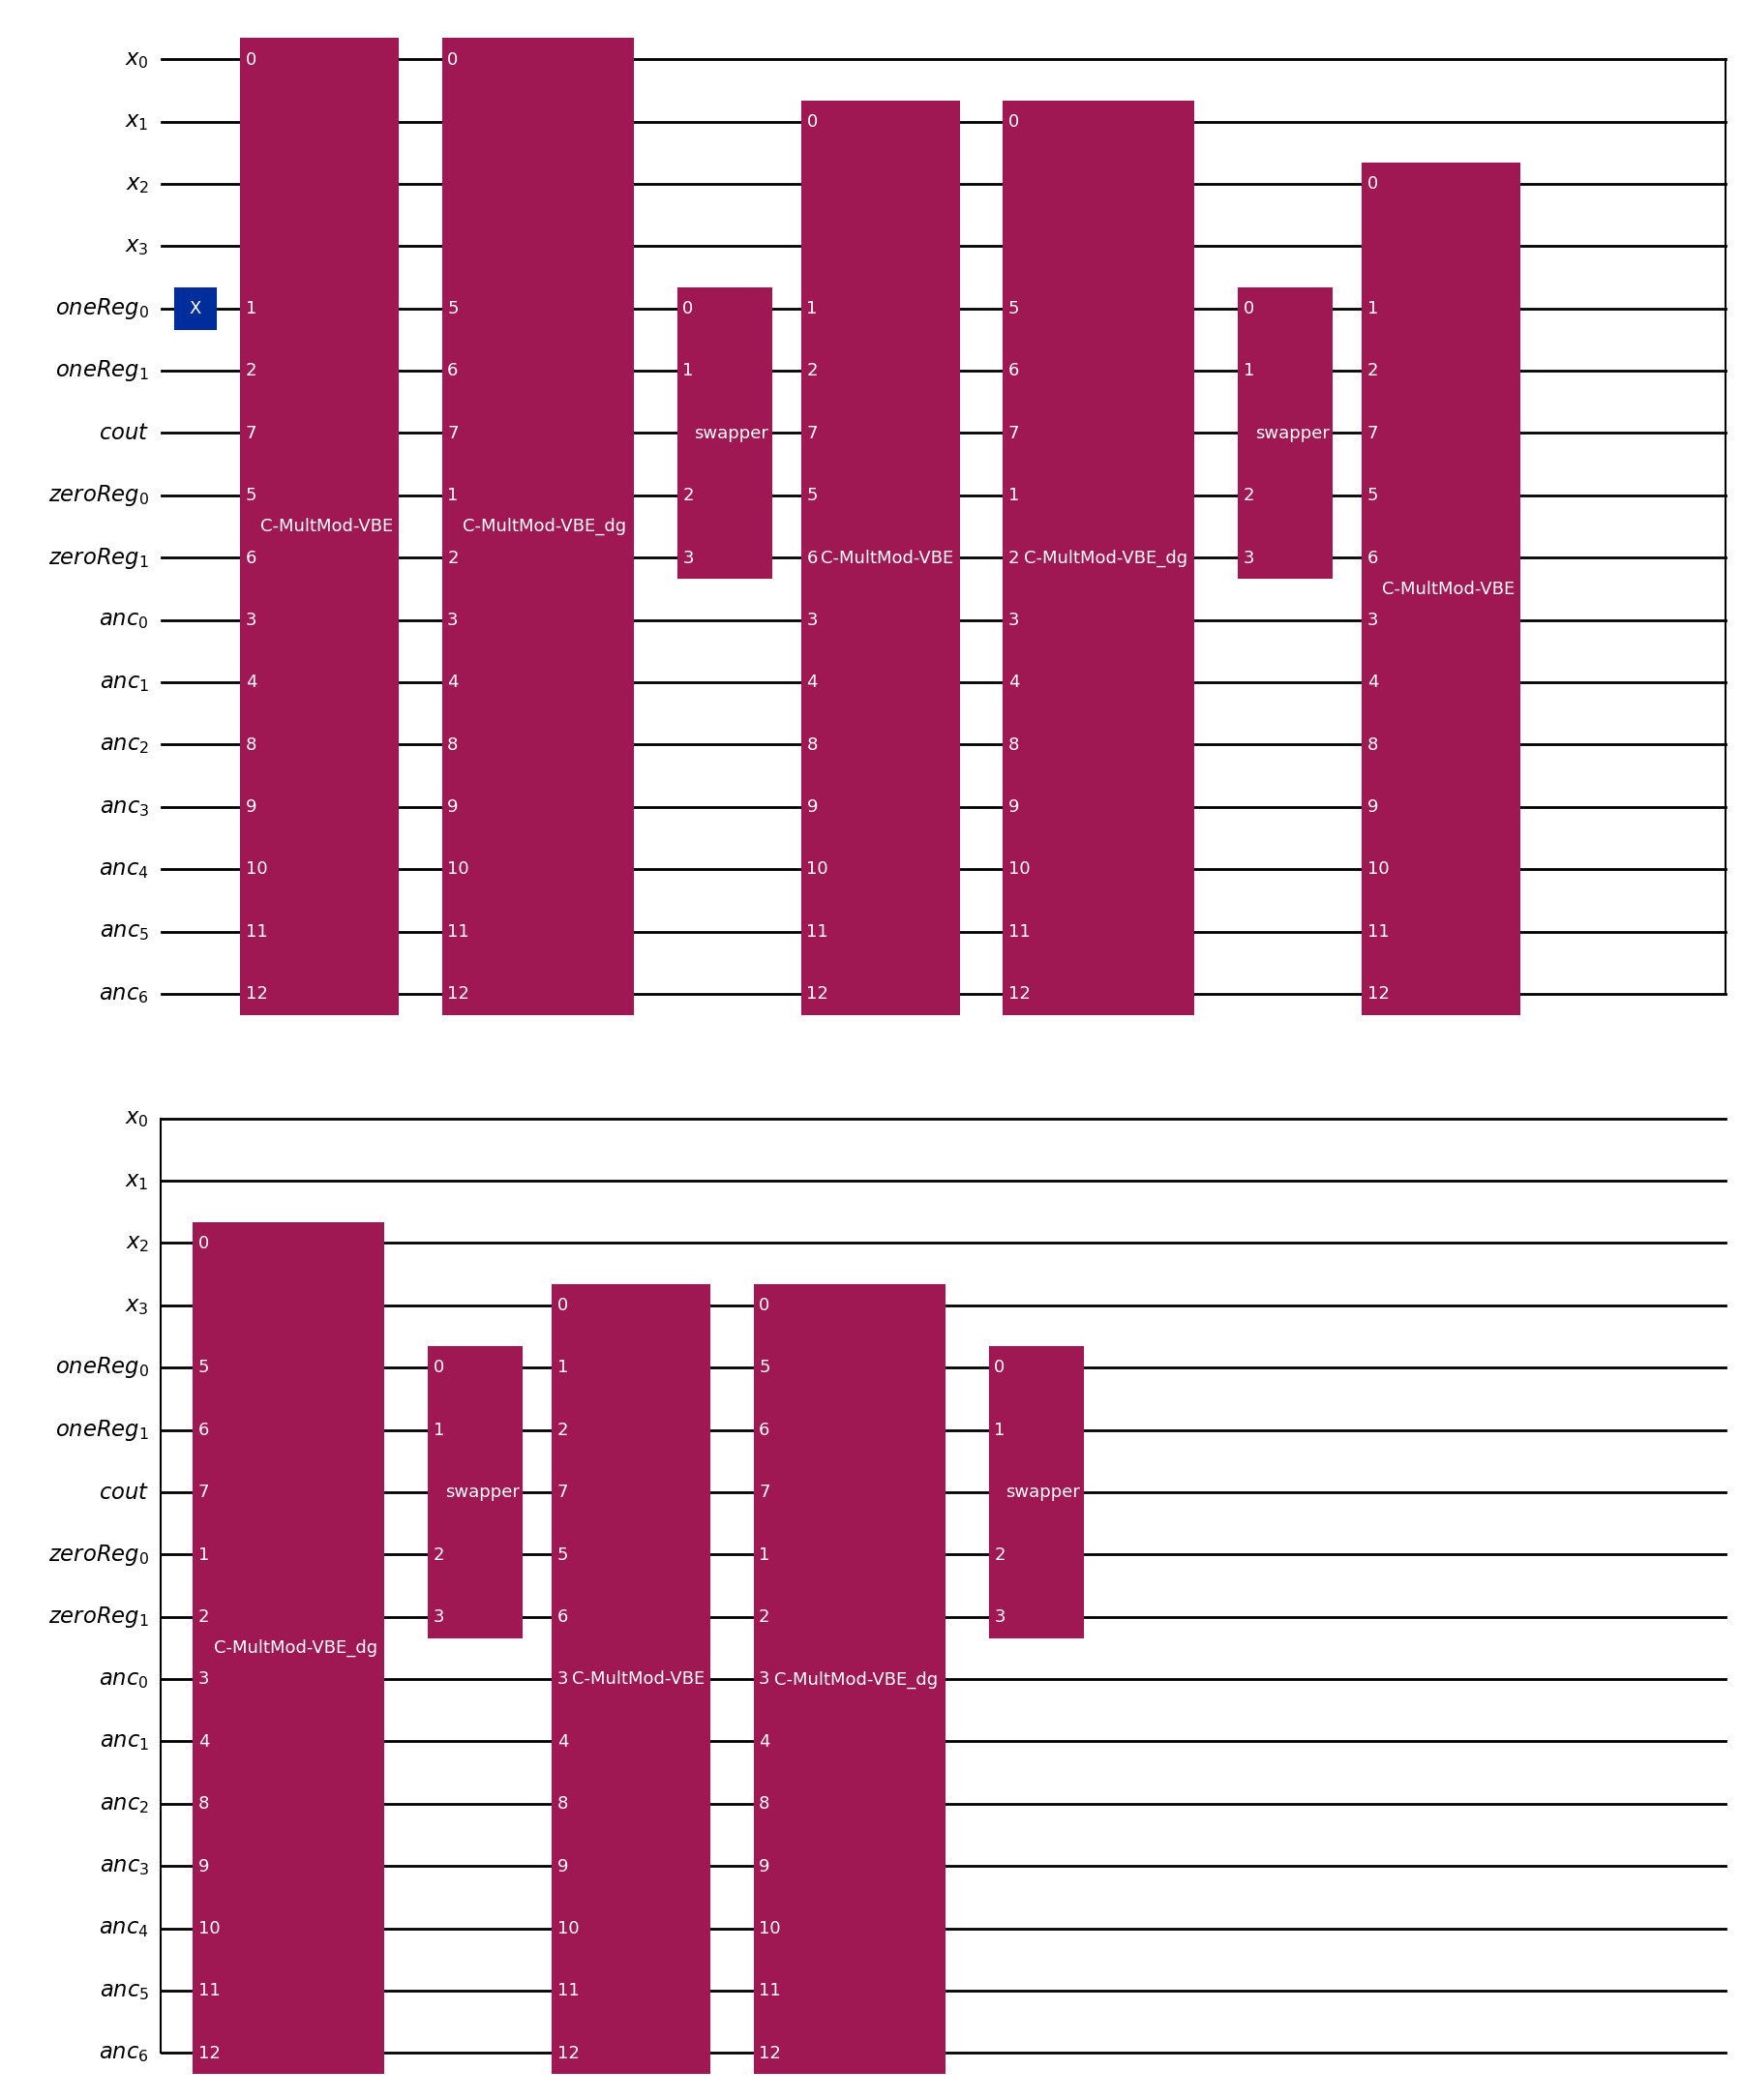

In [62]:
#a^x mod N
def exp_mod_VBE(num_qubits: int, a: int, N: int) -> QuantumCircuit:
    x = QuantumRegister(2*num_qubits, name="x")
    oneReg = QuantumRegister(num_qubits, name="oneReg")
    zeroReg = QuantumRegister(num_qubits, name="zeroReg")
    coutReg = QuantumRegister(1, name="cout")
    anc = AncillaRegister(3*num_qubits + 1, name="anc")
    quantum_circuit = QuantumCircuit(x, oneReg, coutReg, zeroReg, anc)
    quantum_circuit.name = f"ExpMod{N}-VBE"

    #init in 1
    quantum_circuit.x(oneReg[0])

    #perform c-mult-mod and inverse n-times
    for i in range(2*num_qubits):
        a2i = (a**(2**i))%N
        ia2i = mod_inverse(a, i, N)
        quantum_circuit.append(c_mult_mod_VBE(num_qubits, a2i, N), x[i:i+1] + oneReg[:] + anc[0:num_qubits] + zeroReg[:] + coutReg[:] + anc[num_qubits:])
        quantum_circuit.append(c_mult_mod_VBE(num_qubits, ia2i, N).inverse(), x[i:i+1] + zeroReg[:] + anc[0:num_qubits] + oneReg[:] + coutReg[:] + anc[num_qubits:])
        quantum_circuit.append(swapper(num_qubits), oneReg[:] + zeroReg[:])
    return quantum_circuit

exp_mod_VBE(2, 2, 3).draw("mpl")

In [65]:
from qiskit.quantum_info import Statevector

Statevector.from_label("0000000000000011").evolve(exp_mod_VBE(2, 1, 3)).draw("latex")

<IPython.core.display.Latex object>